In [45]:
# ---------------- Standard library ----------------
import os
import random

# ---------------- Data manipulation ----------------
import numpy as np
import pandas as pd

# ---------------- Visualization ----------------
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Signal processing ----------------
from scipy.signal import savgol_filter

# ---------------- Preprocessing ----------------
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# ---------------- Model selection / CV ----------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_validate
)

# ---------------- ML models — Regression ----------------
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

# ---------------- ML models — Classification ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# ---------------- Metrics ----------------
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    make_scorer
)

# ---------------- PyTorch ----------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms

# Preprocesamiento

In [3]:
OUT_DIR="instances_images"
CSV_PATH=os.path.join(OUT_DIR, "graphs_images_flat_16.csv")
df=pd.read_csv(CSV_PATH)
df.head(7)

,instance_name,graph_type,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_246,pixel_247,pixel_248,pixel_249,pixel_250,pixel_251,pixel_252,pixel_253,pixel_254,pixel_255
0,barabasi_n1000_m10_1,barabasi,0.176471,0.043137,0.062745,0.082353,0.062745,0.058824,0.054902,0.047059,...,0.011765,0.011765,0.007843,0.011765,0.011765,0.007843,0.007843,0.011765,0.007843,0.007843
1,barabasi_n1000_m10_10,barabasi,0.117647,0.054902,0.058824,0.062745,0.050980,0.043137,0.047059,0.039216,...,0.015686,0.011765,0.011765,0.011765,0.007843,0.007843,0.007843,0.011765,0.011765,0.007843
2,barabasi_n1000_m10_11,barabasi,0.184314,0.047059,0.058824,0.062745,0.070588,0.050980,0.058824,0.054902,...,0.011765,0.015686,0.011765,0.011765,0.015686,0.011765,0.007843,0.007843,0.007843,0.007843
3,barabasi_n1000_m10_12,barabasi,0.168627,0.066667,0.062745,0.074510,0.050980,0.062745,0.050980,0.054902,...,0.015686,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.007843,0.007843
4,barabasi_n1000_m10_13,barabasi,0.200000,0.050980,0.074510,0.082353,0.050980,0.058824,0.054902,0.058824,...,0.015686,0.011765,0.011765,0.011765,0.011765,0.007843,0.007843,0.007843,0.007843,0.011765
5,barabasi_n1000_m10_14,barabasi,0.160784,0.050980,0.070588,0.062745,0.066667,0.058824,0.050980,0.050980,...,0.011765,0.015686,0.011765,0.011765,0.007843,0.011765,0.011765,0.007843,0.007843,0.007843
6,barabasi_n1000_m10_15,barabasi,0.168627,0.047059,0.066667,0.070588,0.058824,0.062745,0.054902,0.050980,...,0.011765,0.011765,0.011765,0.007843,0.007843,0.011765,0.011765,0.007843,0.007843,0.007843


In [5]:
pixel_cols=[c for c in df.columns if c.startswith("pixel_")]
len(pixel_cols)

256

In [7]:
le = LabelEncoder()

X = df[pixel_cols].values        #pixel_cols
y = le.fit_transform(df["graph_type"].values)      #etiquetas: barabasi / erdos / watt

In [9]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)


In [13]:
#% de varianza acumulada por los componentes de PCA
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza acumulada:", pca.explained_variance_ratio_.cumsum())

Varianza explicada por cada componente: [0.69702856 0.1717936  0.04817497 0.01165558 0.00806597 0.00442965
 0.00322616 0.00197149 0.00187407 0.00159577]
Varianza acumulada: [0.69702856 0.86882216 0.91699713 0.92865271 0.93671868 0.94114833
 0.94437449 0.94634598 0.94822006 0.94981583]


In [19]:
pca_80 = PCA(n_components=0.90)
X_fpca = pca_80.fit_transform(X)

print("Número de componentes seleccionados:", pca_80.n_components_)
print("Varianza acumulada:", pca_80.explained_variance_ratio_.cumsum())

Número de componentes seleccionados: 3
Varianza acumulada: [0.69702856 0.86882216 0.91699713]


In [21]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_fpca, y,
    test_size=0.2,
    random_state=42, stratify=y
)

# Regresión logística

In [23]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100,110,150,200],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

log_reg = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=cv,
    scoring='accuracy',   # podrías usar 'f1_weighted' si te interesa más
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print("Mejores hiperparámetros LogReg:", grid_search_lr.best_params_)

best_lr = grid_search_lr.best_estimator_

def calcular_metricas(modelo, X, y, average='weighted'):
    y_pred = modelo.predict(X)
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average=average, zero_division=0),
        'recall': recall_score(y, y_pred, average=average, zero_division=0),
        'f1': f1_score(y, y_pred, average=average, zero_division=0)
    }

metricas_train_lr = calcular_metricas(best_lr, X_train, y_train)
metricas_test_lr = calcular_metricas(best_lr, X_test, y_test)

resultados_logreg = pd.DataFrame({
    'modelo': ['LogisticRegression'],
    'accuracy_train': [metricas_train_lr['accuracy']],
    'precision_train': [metricas_train_lr['precision']],
    'recall_train': [metricas_train_lr['recall']],
    'f1_train': [metricas_train_lr['f1']],
    'accuracy_test': [metricas_test_lr['accuracy']],
    'precision_test': [metricas_test_lr['precision']],
    'recall_test': [metricas_test_lr['recall']],
    'f1_test': [metricas_test_lr['f1']]
})

print(resultados_logreg)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros LogReg: {'C': 150, 'class_weight': 'balanced', 'penalty': 'l1'}
               modelo  accuracy_train  precision_train  recall_train  \
0  LogisticRegression        0.847222         0.847345      0.847222   

   f1_train  accuracy_test  precision_test  recall_test   f1_test  
0  0.847196       0.861111        0.861196     0.861111  0.861096  


In [27]:
# Predicciones en entrenamiento y test
y_pred_train = best_lr.predict(X_train)
y_pred_test = best_lr.predict(X_test)

# Etiquetas de clase
class_labels = ['BA','ER','WS']

# ============================
# Matriz de confusión - Train
# ============================
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                    display_labels=class_labels)
disp_train.plot(cmap="Blues", values_format="d")
plt.title("Train")
plt.savefig("best_lr_train_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()

# ============================
# Matriz de confusión - Test
# ============================
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                   display_labels=class_labels)
disp_test.plot(cmap="Oranges", values_format="d")
plt.title("Test")
plt.savefig("best_lr_test_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()


In [47]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

cv_results = cross_validate(
    estimator=best_lr,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

metricas_logreg = pd.DataFrame({
    'fold': range(1, cv.n_splits + 1),

    'accuracy_train': cv_results['train_accuracy'],
    'accuracy_test': cv_results['test_accuracy'],

    'precision_train': cv_results['train_precision'],
    'precision_test': cv_results['test_precision'],

    'recall_train': cv_results['train_recall'],
    'recall_test': cv_results['test_recall'],

    'f1_train': cv_results['train_f1'],
    'f1_test': cv_results['test_f1']
})

print(metricas_logreg)

metricas_logreg_long = metricas_logreg.melt(
    id_vars='fold',
    var_name='metrica',
    value_name='valor'
)

print(metricas_logreg_long.head())

   fold  accuracy_train  accuracy_test  precision_train  precision_test  \
0     1        0.838219       0.852814         0.838309        0.852940   
1     2        0.845820       0.839827         0.845941        0.839856   
2     3        0.826464       0.834783         0.826898        0.839003   
3     4        0.850325       0.826087         0.850391        0.826581   
4     5        0.853579       0.852174         0.853633        0.853243   

   recall_train  recall_test  f1_train   f1_test  
0      0.838219     0.852814  0.838198  0.852789  
1      0.845820     0.839827  0.845794  0.839820  
2      0.826464     0.834783  0.826346  0.833773  
3      0.850325     0.826087  0.850309  0.825998  
4      0.853579     0.852174  0.853571  0.851908  
   fold         metrica     valor
0     1  accuracy_train  0.838219
1     2  accuracy_train  0.845820
2     3  accuracy_train  0.826464
3     4  accuracy_train  0.850325
4     5  accuracy_train  0.853579


# Support Vector Machine

In [29]:
param_grid_svc = {
    'C': [0.01,0.1, 1, 10, 100,150,200,250,300,400,500,600],
    #'C': [0.01,0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # relevante para rbf y poly
}

svc = SVC(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=cv,
    scoring='accuracy',   
    n_jobs=-1,
    verbose=1
)

grid_search_svc.fit(X_train, y_train)

print("Mejores hiperparámetros SVC:", grid_search_svc.best_params_)

best_svc = grid_search_svc.best_estimator_

def calcular_metricas(modelo, X, y, average='weighted'):
    y_pred = modelo.predict(X)
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average=average, zero_division=0),
        'recall': recall_score(y, y_pred, average=average, zero_division=0),
        'f1': f1_score(y, y_pred, average=average, zero_division=0)
    }

metricas_train_svc = calcular_metricas(best_svc, X_train, y_train)
metricas_test_svc = calcular_metricas(best_svc, X_test, y_test)

resultados_svc = pd.DataFrame({
    'modelo': ['SVC'],
    'accuracy_train': [metricas_train_svc['accuracy']],
    'precision_train': [metricas_train_svc['precision']],
    'recall_train': [metricas_train_svc['recall']],
    'f1_train': [metricas_train_svc['f1']],
    'accuracy_test': [metricas_test_svc['accuracy']],
    'precision_test': [metricas_test_svc['precision']],
    'recall_test': [metricas_test_svc['recall']],
    'f1_test': [metricas_test_svc['f1']]
})

print(resultados_svc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros SVC: {'C': 500, 'gamma': 'scale', 'kernel': 'rbf'}
  modelo  accuracy_train  precision_train  recall_train  f1_train  \
0    SVC        0.954861         0.954986      0.954861  0.954856   

   accuracy_test  precision_test  recall_test  f1_test  
0         0.9375          0.9375       0.9375   0.9375  


In [49]:
# Predicciones en entrenamiento y test
y_pred_train = best_svc.predict(X_train)
y_pred_test = best_svc.predict(X_test)

# Etiquetas de clase
class_labels = ['BA','ER','WS']

# ============================
# Matriz de confusión - Train
# ============================
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                    display_labels=class_labels)
disp_train.plot(cmap="Blues", values_format="d")
plt.title("Train")
plt.savefig("best_svc_train_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()

# ============================
# Matriz de confusión - Test
# ============================
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                   display_labels=class_labels)
disp_test.plot(cmap="Oranges", values_format="d")
plt.title("Test")
plt.savefig("best_svc_test_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()


In [53]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

cv_results = cross_validate(
    estimator=best_svc,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

metricas_svc = pd.DataFrame({
    'fold': range(1, cv.n_splits + 1),

    'accuracy_train': cv_results['train_accuracy'],
    'accuracy_test': cv_results['test_accuracy'],

    'precision_train': cv_results['train_precision'],
    'precision_test': cv_results['test_precision'],

    'recall_train': cv_results['train_recall'],
    'recall_test': cv_results['test_recall'],

    'f1_train': cv_results['train_f1'],
    'f1_test': cv_results['test_f1']
})

print(metricas_svc)

metricas_svc_long = metricas_svc.melt(
    id_vars='fold',
    var_name='metrica',
    value_name='valor'
)

print(metricas_svc_long.head())


   fold  accuracy_train  accuracy_test  precision_train  precision_test  \
0     1        0.958740       0.930736         0.959051        0.933618   
1     2        0.948969       0.969697         0.948995        0.970980   
2     3        0.958785       0.934783         0.958798        0.938516   
3     4        0.951193       0.952174         0.951339        0.952625   
4     5        0.950108       0.960870         0.950158        0.960916   

   recall_train  recall_test  f1_train   f1_test  
0      0.958740     0.930736  0.958730  0.930549  
1      0.948969     0.969697  0.948967  0.969665  
2      0.958785     0.934783  0.958785  0.934559  
3      0.951193     0.952174  0.951186  0.952162  
4      0.950108     0.960870  0.950107  0.960866  
   fold         metrica     valor
0     1  accuracy_train  0.958740
1     2  accuracy_train  0.948969
2     3  accuracy_train  0.958785
3     4  accuracy_train  0.951193
4     5  accuracy_train  0.950108


# Random Forest

In [33]:

param_grid_rf = {
    'n_estimators': [10,50,100,150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5,7,10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros RF:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_

def calcular_metricas(modelo, X, y, average='weighted'):
    y_pred = modelo.predict(X)
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average=average, zero_division=0),
        'recall': recall_score(y, y_pred, average=average, zero_division=0),
        'f1': f1_score(y, y_pred, average=average, zero_division=0)
    }


metricas_train = calcular_metricas(best_rf, X_train, y_train)
metricas_test = calcular_metricas(best_rf, X_test, y_test)

resultados_rf = pd.DataFrame({
    'modelo': ['RandomForest'],
    'accuracy_train': [metricas_train['accuracy']],
    'precision_train': [metricas_train['precision']],
    'recall_train': [metricas_train['recall']],
    'f1_train': [metricas_train['f1']],
    'accuracy_test': [metricas_test['accuracy']],
    'precision_test': [metricas_test['precision']],
    'recall_test': [metricas_test['recall']],
    'f1_test': [metricas_test['f1']]
})

print(resultados_rf)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Mejores hiperparámetros RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
         modelo  accuracy_train  precision_train  recall_train  f1_train  \
0  RandomForest             1.0              1.0           1.0       1.0   

   accuracy_test  precision_test  recall_test   f1_test  
0       0.989583        0.989618     0.989583  0.989583  


In [55]:
# Predicciones en entrenamiento y test
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Etiquetas de clase
class_labels = ['BA','ER','WS']

# ============================
# Matriz de confusión - Train
# ============================
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                    display_labels=class_labels)
disp_train.plot(cmap="Blues", values_format="d")
plt.title("Train")
plt.savefig("best_rf_train_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()

# ============================
# Matriz de confusión - Test
# ============================
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                   display_labels=class_labels)
disp_test.plot(cmap="Oranges", values_format="d")
plt.title("Test")
plt.savefig("best_rf_test_confusion.png", dpi=300, bbox_inches="tight")  # Guardar
plt.close()


In [57]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

cv_results = cross_validate(
    estimator=best_rf,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

metricas_rf = pd.DataFrame({
    'fold': range(1, cv.n_splits + 1),

    'accuracy_train': cv_results['train_accuracy'],
    'accuracy_test': cv_results['test_accuracy'],

    'precision_train': cv_results['train_precision'],
    'precision_test': cv_results['test_precision'],

    'recall_train': cv_results['train_recall'],
    'recall_test': cv_results['test_recall'],

    'f1_train': cv_results['train_f1'],
    'f1_test': cv_results['test_f1']
})

print(metricas_rf)

metricas_rf_long = metricas_rf.melt(
    id_vars='fold',
    var_name='metrica',
    value_name='valor'
)

print(metricas_rf_long.head())


   fold  accuracy_train  accuracy_test  precision_train  precision_test  \
0     1        0.998914       0.978355         0.998918        0.978829   
1     2        1.000000       0.991342         1.000000        0.991342   
2     3        1.000000       0.995652         1.000000        0.995708   
3     4        0.998915       0.995652         0.998919        0.995708   
4     5        1.000000       1.000000         1.000000        1.000000   

   recall_train  recall_test  f1_train   f1_test  
0      0.998914     0.978355  0.998914  0.978347  
1      1.000000     0.991342  1.000000  0.991342  
2      1.000000     0.995652  1.000000  0.995652  
3      0.998915     0.995652  0.998915  0.995652  
4      1.000000     1.000000  1.000000  1.000000  
   fold         metrica     valor
0     1  accuracy_train  0.998914
1     2  accuracy_train  1.000000
2     3  accuracy_train  1.000000
3     4  accuracy_train  0.998915
4     5  accuracy_train  1.000000


# Métricas generales de ML

In [60]:
metricas_logreg_long['modelo'] = 'LogReg'
metricas_svc_long['modelo']    = 'SVC'
metricas_rf_long['modelo']     = 'RF'

metricas_all = pd.concat(
    [metricas_logreg_long, metricas_svc_long, metricas_rf_long],
    ignore_index=True
)

metricas_train = metricas_all[metricas_all['metrica'].str.endswith('_train')].copy()
metricas_test  = metricas_all[metricas_all['metrica'].str.endswith('_test')].copy()

metricas_train['metrica'] = metricas_train['metrica'].str.replace('_train', '', regex=False)
metricas_test['metrica']  = metricas_test['metrica'].str.replace('_test', '', regex=False)


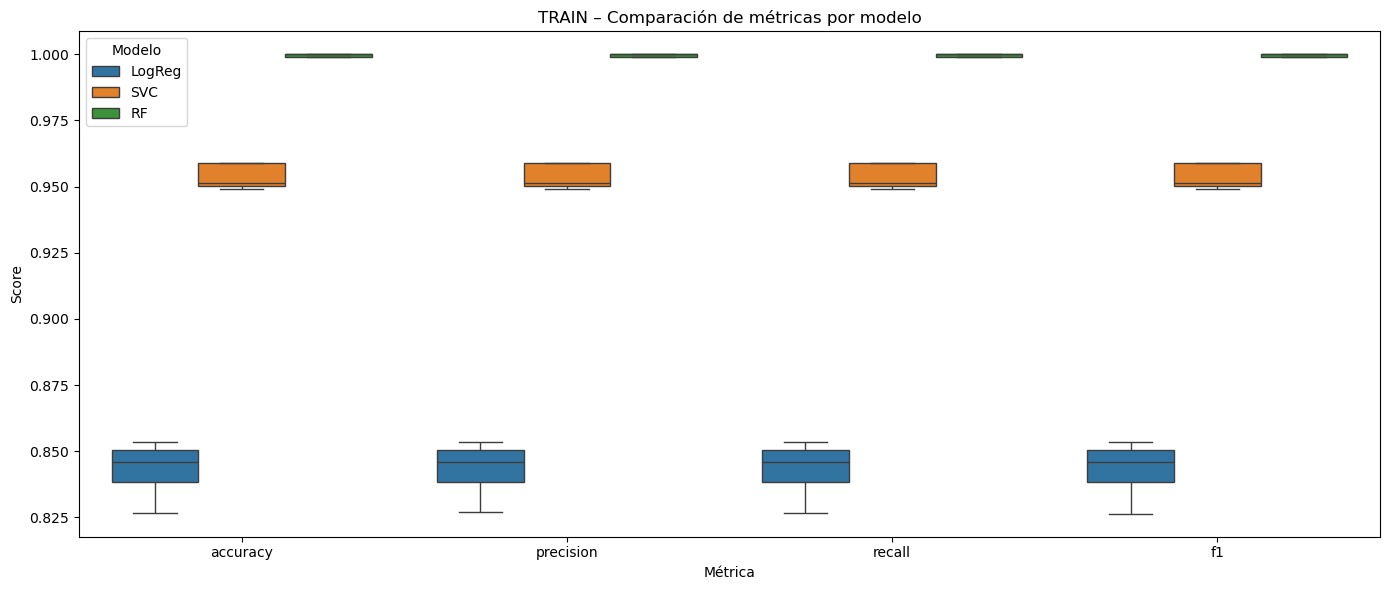

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.boxplot(
    data=metricas_train,
    x='metrica',
    y='valor',
    hue='modelo'
)

plt.title('TRAIN – Comparación de métricas por modelo')
plt.ylabel('Score')
plt.xlabel('Métrica')
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()


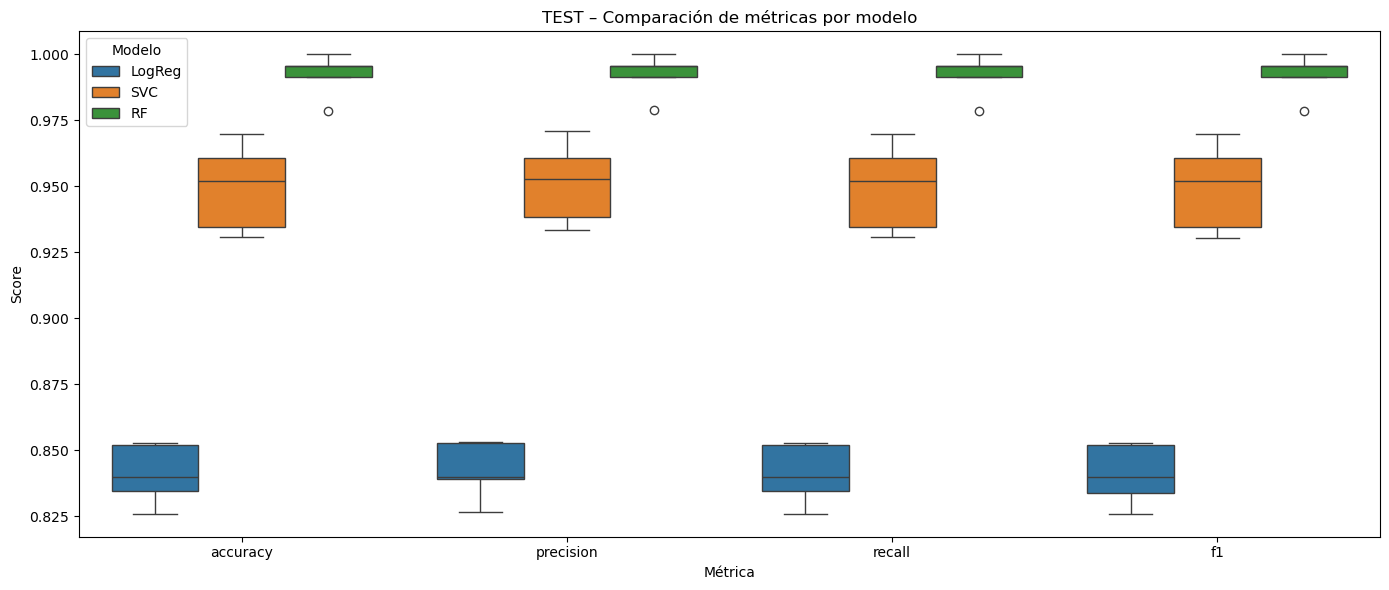

In [64]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=metricas_test,
    x='metrica',
    y='valor',
    hue='modelo'
)

plt.title('TEST – Comparación de métricas por modelo')
plt.ylabel('Score')
plt.xlabel('Métrica')
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()


# Deep Learning: MLP

In [76]:
# =========================================
# Preparar datos para formato de MLP
# =========================================
learning_rate = 1e-3
n_epochs = 2000
hidden_size = 32

# odificar etiquetas
le = LabelEncoder()
df['label'] = le.fit_transform(df["graph_type"].values)
X = df.drop(['instance_name', 'graph_type', 'label'], axis=1)

y = df['label']   

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [150]:
# ============================================================
# Hiperparámetros
# ============================================================
learning_rate = 1e-3
n_epochs = 2000
hidden_size = 32
seed = 42

# ============================================================
# 1. Semilla 
# ============================================================
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.use_deterministic_algorithms(False) 

# ============================================================
# 2. Preparar datos
# ============================================================
le = LabelEncoder()
df["label"] = le.fit_transform(df["graph_type"].values)  # 3 clases

X = df.drop(columns=["instance_name", "graph_type", "label"])
y = df["label"]

X_train_df, X_test_df, y_train_ser, y_test_ser = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

# ============================================================
# 3. Tensores (importante!)
# ============================================================
X_train = torch.tensor(X_train_df.to_numpy(), dtype=torch.float32)
X_test  = torch.tensor(X_test_df.to_numpy(),  dtype=torch.float32)
y_train = torch.tensor(y_train_ser.to_numpy(), dtype=torch.long)
y_test  = torch.tensor(y_test_ser.to_numpy(),  dtype=torch.long)

# ============================================================
# 4. Definir MLP
# ============================================================
class MLP_cls(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.h1 = nn.Linear(in_features=256, out_features=hidden_size)
        self.out = nn.Linear(in_features=hidden_size, out_features=3)
        self.act = nn.ReLU()

    def forward(self, x):
        h = self.act(self.h1(x))
        return self.out(h)

m1 = MLP_cls(hidden_size)
print(m1)

total_params = sum(p.numel() for p in m1.parameters())
print("Number of parameters:", total_params)

# ============================================================
# 5. Loss + Opt (usando Adam)
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m1.parameters(), lr=learning_rate)

# ============================================================
# 6. Entrenamiento + almacenar métricas
# ============================================================
train_losses, test_losses = [], []

metricas_mlp = {
    "epoch": [],
    "accuracy_train": [], "precision_train": [], "recall_train": [], "f1_train": [],
    "accuracy_test":  [], "precision_test":  [], "recall_test":  [], "f1_test":  []
}

for epoch in range(n_epochs):

    # Train

    m1.train()
    outputs = m1(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    preds_train = outputs.argmax(dim=1)

    y_true_train = y_train.detach().cpu().numpy()
    y_pred_train = preds_train.detach().cpu().numpy()

    acc_train  = accuracy_score(y_true_train, y_pred_train)
    prec_train = precision_score(y_true_train, y_pred_train, average="macro", zero_division=0)
    rec_train  = recall_score(y_true_train, y_pred_train, average="macro", zero_division=0)
    f1_train   = f1_score(y_true_train, y_pred_train, average="macro", zero_division=0)

    # Test

    m1.eval()
    with torch.no_grad():
        test_outputs = m1(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

        preds_test = test_outputs.argmax(dim=1)

        y_true_test = y_test.detach().cpu().numpy()
        y_pred_test = preds_test.detach().cpu().numpy()

        acc_test  = accuracy_score(y_true_test, y_pred_test)
        prec_test = precision_score(y_true_test, y_pred_test, average="macro", zero_division=0)
        rec_test  = recall_score(y_true_test, y_pred_test, average="macro", zero_division=0)
        f1_test   = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)


    # Guardar métricas

    metricas_mlp["epoch"].append(epoch + 1)

    metricas_mlp["accuracy_train"].append(acc_train)
    metricas_mlp["precision_train"].append(prec_train)
    metricas_mlp["recall_train"].append(rec_train)
    metricas_mlp["f1_train"].append(f1_train)

    metricas_mlp["accuracy_test"].append(acc_test)
    metricas_mlp["precision_test"].append(prec_test)
    metricas_mlp["recall_test"].append(rec_test)
    metricas_mlp["f1_test"].append(f1_test)

    # Log
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{n_epochs}] - "
            f"Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f} | "
            f"Train Acc: {acc_train:.3f} | Test Acc: {acc_test:.3f} | "
            f"Train F1: {f1_train:.3f} | Test F1: {f1_test:.3f}"
        )

# ============================================================
# 7. df de métricas
# ============================================================
metricas_mlp_df = pd.DataFrame(metricas_mlp)

metricas_mlp_long = metricas_mlp_df.melt(
    id_vars="epoch",
    var_name="metrica",
    value_name="valor"
)

print("\nÚltimas filas (wide):")
print(metricas_mlp_df.tail())

print("\nPrimeras filas (long):")
print(metricas_mlp_long.head())

# ============================================================
# 8. Accuracy final
# ============================================================
print(f"\nAccuracy final train: {metricas_mlp_df['accuracy_train'].iloc[-1]:.3f}")
print(f"Accuracy final test:  {metricas_mlp_df['accuracy_test'].iloc[-1]:.3f}")

# ============================================================
# 9. Gráfica de pérdidas
# ============================================================
plt.figure(figsize=(9, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_mlp.png", dpi=300, bbox_inches="tight")
plt.close()

# ============================================================
# 10. Gráfica accuracy
# ============================================================
plt.figure(figsize=(9, 5))
plt.plot(metricas_mlp_df["accuracy_train"], label="Train Accuracy")
plt.plot(metricas_mlp_df["accuracy_test"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig("accuracy_mlp.png", dpi=300, bbox_inches="tight")
plt.close()

# (Opcional) Gráfica F1 (train/test)
plt.figure(figsize=(9, 5))
plt.plot(metricas_mlp_df["f1_train"], label="Train F1")
plt.plot(metricas_mlp_df["f1_test"], label="Test F1")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig("f1_mlp.png", dpi=300, bbox_inches="tight")
plt.close()


MLP_cls(
  (h1): Linear(in_features=256, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
  (act): ReLU()
)
Number of parameters: 8323
Epoch [5/2000] - Train Loss: 1.0961 | Test Loss: 1.0955 | Train Acc: 0.490 | Test Acc: 0.587 | Train F1: 0.402 | Test F1: 0.494
Epoch [10/2000] - Train Loss: 1.0934 | Test Loss: 1.0929 | Train Acc: 0.792 | Test Acc: 0.792 | Train F1: 0.773 | Test F1: 0.783
Epoch [15/2000] - Train Loss: 1.0903 | Test Loss: 1.0898 | Train Acc: 0.787 | Test Acc: 0.785 | Train F1: 0.770 | Test F1: 0.766
Epoch [20/2000] - Train Loss: 1.0867 | Test Loss: 1.0862 | Train Acc: 0.806 | Test Acc: 0.833 | Train F1: 0.798 | Test F1: 0.828
Epoch [25/2000] - Train Loss: 1.0826 | Test Loss: 1.0820 | Train Acc: 0.892 | Test Acc: 0.885 | Train F1: 0.892 | Test F1: 0.883
Epoch [30/2000] - Train Loss: 1.0779 | Test Loss: 1.0773 | Train Acc: 0.744 | Test Acc: 0.750 | Train F1: 0.700 | Test F1: 0.709
Epoch [35/2000] - Train Loss: 1.0727 | Test Loss: 1.07

In [ ]:
# Etiquetas de clase
class_labels = ['BA','ER','WS']

# ============================
# Matriz de confusión - Train
# ============================
cm_train = confusion_matrix(y_train, y_hat_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                    display_labels=class_labels)
disp_train.plot(cmap="Blues", values_format="d")
plt.title("Train")
plt.savefig("mlp_train_confusion.png", dpi=300, bbox_inches="tight")
plt.close()

# ============================
# Matriz de confusión - Test
# ============================
cm_test = confusion_matrix(y_test, y_hat_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                   display_labels=class_labels)
disp_test.plot(cmap="Oranges", values_format="d")
plt.title("Test")
plt.savefig("mlp_test_confusion.png", dpi=300, bbox_inches="tight")
plt.close()


# Representación métricas ML clásico + DL

In [152]:
metricas_mlp_long = metricas_mlp_long.rename(columns={"epoch": "fold"})
metricas_mlp_long["modelo"] = "MLP"

metricas_mlp_long = metricas_mlp_long[
    metricas_mlp_long['fold'] >= 1500
].copy()

In [182]:
# Las métricas de la CNN se exportan desde el archivo metricas_cnn.xlsx. Desde ahora, las operaciones se aplican para concatenar las métricas de RL, SVM, RF, MLP y CNN con objetvo de poder construir un Box plot.

metricas_cnn_df = pd.read_excel(
    "metricas_cnn.xlsx"
)

metricas_cnn_long = metricas_cnn_df.melt(
    id_vars="epoch",
    var_name="metrica",
    value_name="valor"
)

metricas_cnn_long = metricas_cnn_long.rename(columns={"epoch": "fold"})
metricas_cnn_long["modelo"] = "CNN"

metricas_logreg_long["modelo"] = "LogReg"
metricas_svc_long["modelo"]    = "SVC"
metricas_rf_long["modelo"]     = "RF"
metricas_mlp_long["modelo"]    = "MLP"

metricas_all = pd.concat(
    [
        metricas_logreg_long,
        metricas_svc_long,
        metricas_rf_long,
        metricas_mlp_long,
        metricas_cnn_long      # ← CNN añadido
    ],
    ignore_index=True
)

metricas_train = metricas_all[
    metricas_all["metrica"].str.endswith("_train")
].copy()

metricas_test = metricas_all[
    metricas_all["metrica"].str.endswith("_test")
].copy()

metricas_train["metrica"] = metricas_train["metrica"].str.replace("_train", "", regex=False)
metricas_test["metrica"]  = metricas_test["metrica"].str.replace("_test", "", regex=False)

metricas_train = metricas_train[
    ~((metricas_train["modelo"] == "CNN") & (metricas_train["fold"] < 20))
]

metricas_test = metricas_test[
    ~((metricas_test["modelo"] == "CNN") & (metricas_test["fold"] < 20))
]

In [154]:
metricas_logreg_long['modelo'] = 'LogReg'
metricas_svc_long['modelo']    = 'SVC'
metricas_rf_long['modelo']     = 'RF'

metricas_all = pd.concat(
    [
        metricas_logreg_long,
        metricas_svc_long,
        metricas_rf_long,
        metricas_mlp_long      
    ],
    ignore_index=True
)

metricas_train = metricas_all[
    metricas_all['metrica'].str.endswith('_train')
].copy()

metricas_test = metricas_all[
    metricas_all['metrica'].str.endswith('_test')
].copy()

metricas_train['metrica'] = metricas_train['metrica'].str.replace('_train', '', regex=False)
metricas_test['metrica']  = metricas_test['metrica'].str.replace('_test', '', regex=False)



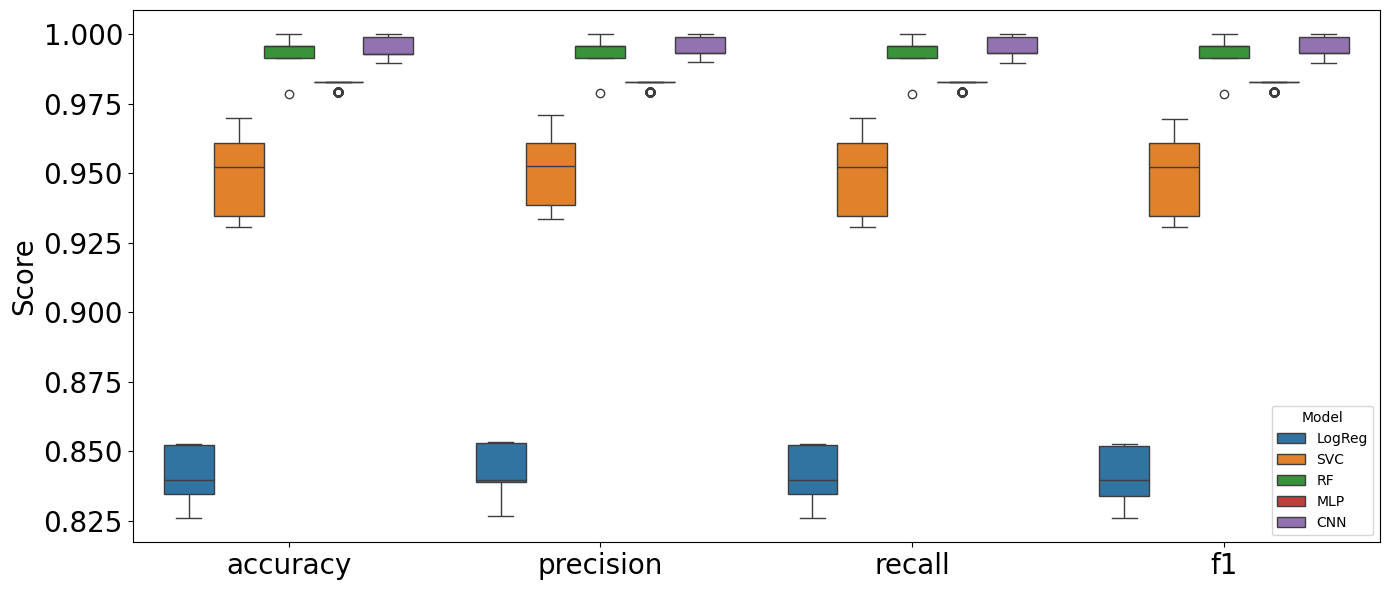

In [193]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=metricas_test,
    x='metrica',
    y='valor',
    hue='modelo'
)

#plt.title('Test')
plt.ylabel('Score',fontsize=20)
plt.xlabel('')
plt.xticks(fontsize=20)            
plt.yticks(fontsize=20) 
plt.legend(title='Model')
plt.tight_layout()
plt.savefig("metricas_test.png", dpi=300, bbox_inches="tight")
plt.show()


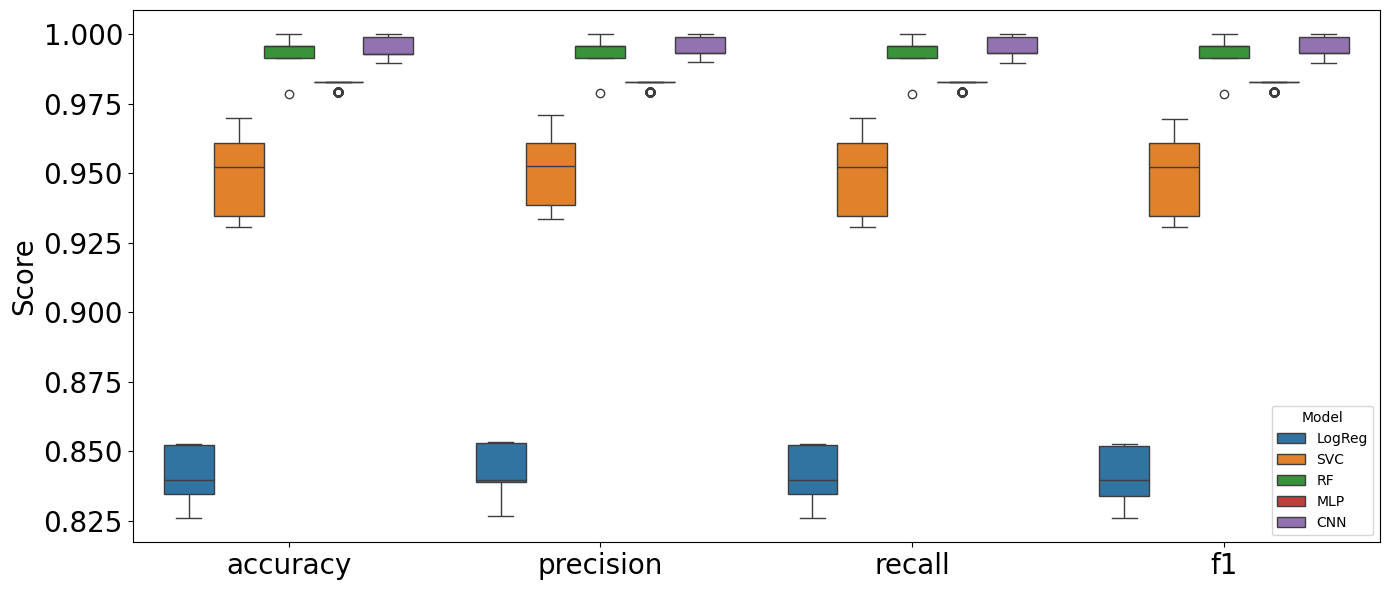

In [195]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=metricas_test,
    x='metrica',
    y='valor',
    hue='modelo'
)

#plt.title('Train')
plt.ylabel('Score',fontsize=20)
plt.xlabel('')
plt.xticks(fontsize=20)            
plt.yticks(fontsize=20) 
plt.legend(title='Model')
plt.tight_layout()
plt.savefig("metricas_train.png", dpi=300, bbox_inches="tight")
plt.show()
